## Collaborative Filtering

In [ ]:
# took a look at this one for movies - good goes through nlp, movies etc
# https://www.analyticsvidhya.com/blog/2020/08/recommendation-system-k-nearest-neighbors/

# https://aman-makwana101932.medium.com/understanding-recommendation-system-and-knn-with-project-book-recommendation-system-c648e47ff4f6

In [37]:
# import pandas
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

We will create an recommender engine based on Item Based Collaborative Filtering (IBCF) which searches for the most similar books based on the user ratings. We can download the data from [here](https://drive.google.com/file/d/1WvTmAfO09TCX7xp7uu06__ziic7JnrL5/view?usp=sharing).

In [2]:
book_ratings = pd.read_csv('data/BX-Book-Ratings.csv',sep=";", encoding="latin")
books = pd.read_csv('data/BX-Books.csv',sep=";", encoding="latin", error_bad_lines=False)

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
/Users/lilakelland/opt/anaconda3/envs/test_env/lib/python3.6/site-packages

* Explore both datasets

In [3]:
book_ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [4]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


* create dataframe with name 'df_book_features' from book_ratings that have `ISBN` as index, `User-ID` as columns and values are `Book-Rating`.
    - The data are quite big so it's OK to use a sample only in case your PC has limited RAM.


(1149780, 3)
['User-ID', 'ISBN', 'Book-Rating']


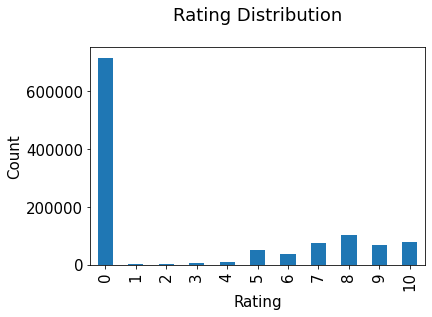

(271360, 8)
['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']


In [21]:
# from article above
import matplotlib.pyplot as plt
print(book_ratings.shape)
print(list(book_ratings.columns))
plt.rc("font", size=15)
book_ratings['Book-Rating'].value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('system1.png', bbox_inches='tight')
plt.show()
print(books.shape)
print(list(books.columns))


In [24]:
# from article - ensure statiscical significance, users less than 200 ratings and books less than 100 ratings excluede
counts1 = book_ratings['User-ID'].value_counts()
book_ratings = book_ratings[book_ratings['User-ID'].isin(counts1[counts1 >= 200].index)]
counts = book_ratings['Book-Rating'].value_counts()
book_ratings = book_ratings[book_ratings['Book-Rating'].isin(counts[counts >= 100].index)]

kNN is a machine learning algorithm to find clusters of similar users based on common book ratings, and make predictions using the average rating of top-k nearest neighbors. For example, we first present ratings in a matrix with the matrix having one row for each item (book) and one column for each user,

In [28]:
# row per book, and column per user 
combine_book_rating = pd.merge(book_ratings, books, on='ISBN')
columns = ['Year-Of-Publication', 'Publisher', 'Book-Author', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']
combine_book_rating = combine_book_rating.drop(columns, axis=1)
combine_book_rating.head()

,User-ID,ISBN,Book-Rating,Book-Title
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...


In [32]:
# group by book titles - get rating count like below
combine_book_rating = combine_book_rating.dropna(axis = 0, subset = ['Book-Title'])
book_ratingCount = (combine_book_rating.
groupby(by = ['Book-Title'])['Book-Rating'].count().reset_index().
                rename(columns = {'Book-Rating': 'totalRatingCount'})[['Book-Title', 'totalRatingCount']])
book_ratingCount.head()

,Book-Title,totalRatingCount
0,A Light in the Storm: The Civil War Diary of ...,2
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,Beyond IBM: Leadership Marketing and Finance ...,1
4,Clifford Visita El Hospital (Clifford El Gran...,1


In [34]:
# combine the rating data with the total rating count data, filter out less popular
rating_with_totalRatingCount = combine_book_rating.merge(book_ratingCount, left_on = 'Book-Title', right_on = 'Book-Title', how = 'left')
rating_with_totalRatingCount.head()

,User-ID,ISBN,Book-Rating,Book-Title,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,82
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82


In [35]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(book_ratingCount['totalRatingCount'].describe())

# looks like median (50% only rated once)

count   160576.000
mean         3.044
std          7.428
min          1.000
25%          1.000
50%          1.000
75%          2.000
max        365.000
Name: totalRatingCount, dtype: float64


In [38]:
# look at top 
print(book_ratingCount['totalRatingCount'].quantile(np.arange(.9, 1, .01)))

0.900    5.000
0.910    6.000
0.920    7.000
0.930    7.000
0.940    8.000
0.950   10.000
0.960   11.000
0.970   14.000
0.980   19.000
0.990   31.000
Name: totalRatingCount, dtype: float64


In [40]:
popularity_threshold = 50
rating_popular_book = rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
print(rating_popular_book.shape)
rating_popular_book.head()

(62149, 5)


,User-ID,ISBN,Book-Rating,Book-Title,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,82
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82


### Implementing kNN
#### Still from reference above
We convert our table to a 2D matrix, and fill the missing values with zeros (since we will calculate distances between rating vectors). We then transform the values(ratings) of the matrix dataframe into a scipy sparse matrix for more efficient calculations.
Finding the Nearest Neighbors We use unsupervised algorithms with sklearn.neighbors. The algorithm we use to compute the nearest neighbors is “brute”, and we specify “metric=cosine” so that the algorithm will calculate the cosine similarity between rating vectors. Finally, we fit the model.

In [45]:
from scipy.sparse import csr_matrix
us_canada_user_rating = rating_popular_book
us_canada_user_rating = us_canada_user_rating.drop_duplicates(['User-ID', 'Book-Title'])
us_canada_user_rating_pivot = us_canada_user_rating.pivot(index = 'Book-Title', columns = 'User-ID', values = 'Book-Rating').fillna(0)
us_canada_user_rating_matrix = csr_matrix(us_canada_user_rating_pivot.values)

# from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(us_canada_user_rating_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

create function that returns top 5 most similar movies (according to KNN model) for selected ISBN
* the input will be Book-Title from the DataFrame books
* the output will be the Book-Titles of the top 5 most similar books.
* for every book in the top 5 most similar books, print also the distance from the selected book (ISBN we chose as input to the function)

In [46]:
# now we are randomly selecting any one index of the books and based on that we are giving recommendation on that.
query_index = np.random.choice(us_canada_user_rating_pivot.shape[0])
print(query_index)
distances, indices = model_knn.kneighbors(us_canada_user_rating_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)

420


In [49]:
# now as per the book index randomly coming we are giving 5 books recommendation.
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(us_canada_user_rating_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, us_canada_user_rating_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Rising Sun:

1: Jurassic Park, with distance of 0.7217282033231769:
2: Fatal Cure, with distance of 0.7658663719227591:
3: The Bonfire of the Vanities, with distance of 0.7685233618276859:
4: Absolute Power, with distance of 0.7804340045127087:
5: The Princess Bride: S Morgenstern's Classic Tale of True Love and High Adventure, with distance of 0.7809269184472049:


* Apply the function to book of your choice

### THIS WAS FROM BEFORE ON MY OWN

In [5]:
book_data = pd.merge(book_ratings, books, on="ISBN")
print(book_data.shape)
book_data = book_data.copy()[['User-ID', 'ISBN', 'Book-Rating', 'Book-Title']]
book_data.head()

# take subsection 
book_data = book_data.head(20000)
print(book_data.shape)

(1031136, 10)
(20000, 4)


store_data = pd.read_csv('D:\\Datasets\\store_data.csv', header=None)
store_data.head()

In [6]:
# Avg rating per book
book_data.groupby('ISBN')['Book-Rating'].mean().sort_values(ascending=False).head()

ISBN
0385264356    10.0
3125785006    10.0
3821815191    10.0
0375901582    10.0
0805057706     9.5
Name: Book-Rating, dtype: float64

In [7]:
# combine avg rating and rating count
ratings_mean_count = pd.DataFrame(book_data.groupby('ISBN')['Book-Rating'].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(book_data.groupby('ISBN')['Book-Rating'].count())
ratings_mean_count.head()

,Book-Rating,rating_counts
ISBN,,
000225669X,6.000000,1
0006379702,6.000000,3
002542730X,3.514620,171
0060011939,4.222222,9
0060096195,4.028037,107


In [8]:
df_book_features = book_data.pivot_table(index='User-ID', columns='ISBN', values='Book-Rating')
df_book_features.head()

ISBN,000225669X,0006379702,002542730X,0060011939,0060096195,0060505885,0060517794,0060520507,0060542845,0060930187,...,8807813858,8817106100,8831760122,8833908488,8838910987,884590184X,950491036X,9508521481,9681500830,9871138016
User-ID,,,,,,,,,,,,,,,,,,,,,
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* create the instance of the NearestNeighbors class

In [41]:

from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(df_book_features)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [9]:
# neigh = NearestNeighbors(n_neighbors=2, radius=0.4) # k usually 2 or sqrt(n)


* fit the NearestNeighbors using'df_book_features'

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(df_book_features[0:1], df_book_features)
array([[ 1.        ,  0.36651513,  0.52305744,  0.13448867]])


# neigh.fit(df_book_features)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

* create function that returns top 5 most similar movies (according to KNN model) for selected ISBN
    * the input will be Book-Title from the DataFrame books 
    * the output will be the Book-Titles of the top 5 most similar books.
    * for every book in the top 5 most similar books, print also the distance from the selected book (ISBN we chose as input to the function)

* Apply the function to book of your choice